In [1]:
library(Matrix)
library(tidyverse)
library(data.table)
library(matrixStats)
library(gridExtra)
library(showtext)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The followi

In [2]:
n <- 40
ct <- 1
result.glmm <- readRDS(str_c('results/glmm','n',n,'ct',ct,'rds',sep='.'))
result.pb <- readRDS(str_c('results/pb','n',n,'ct',ct,'rds',sep='.'))

No id variables; using all as measure variables

No id variables; using all as measure variables

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


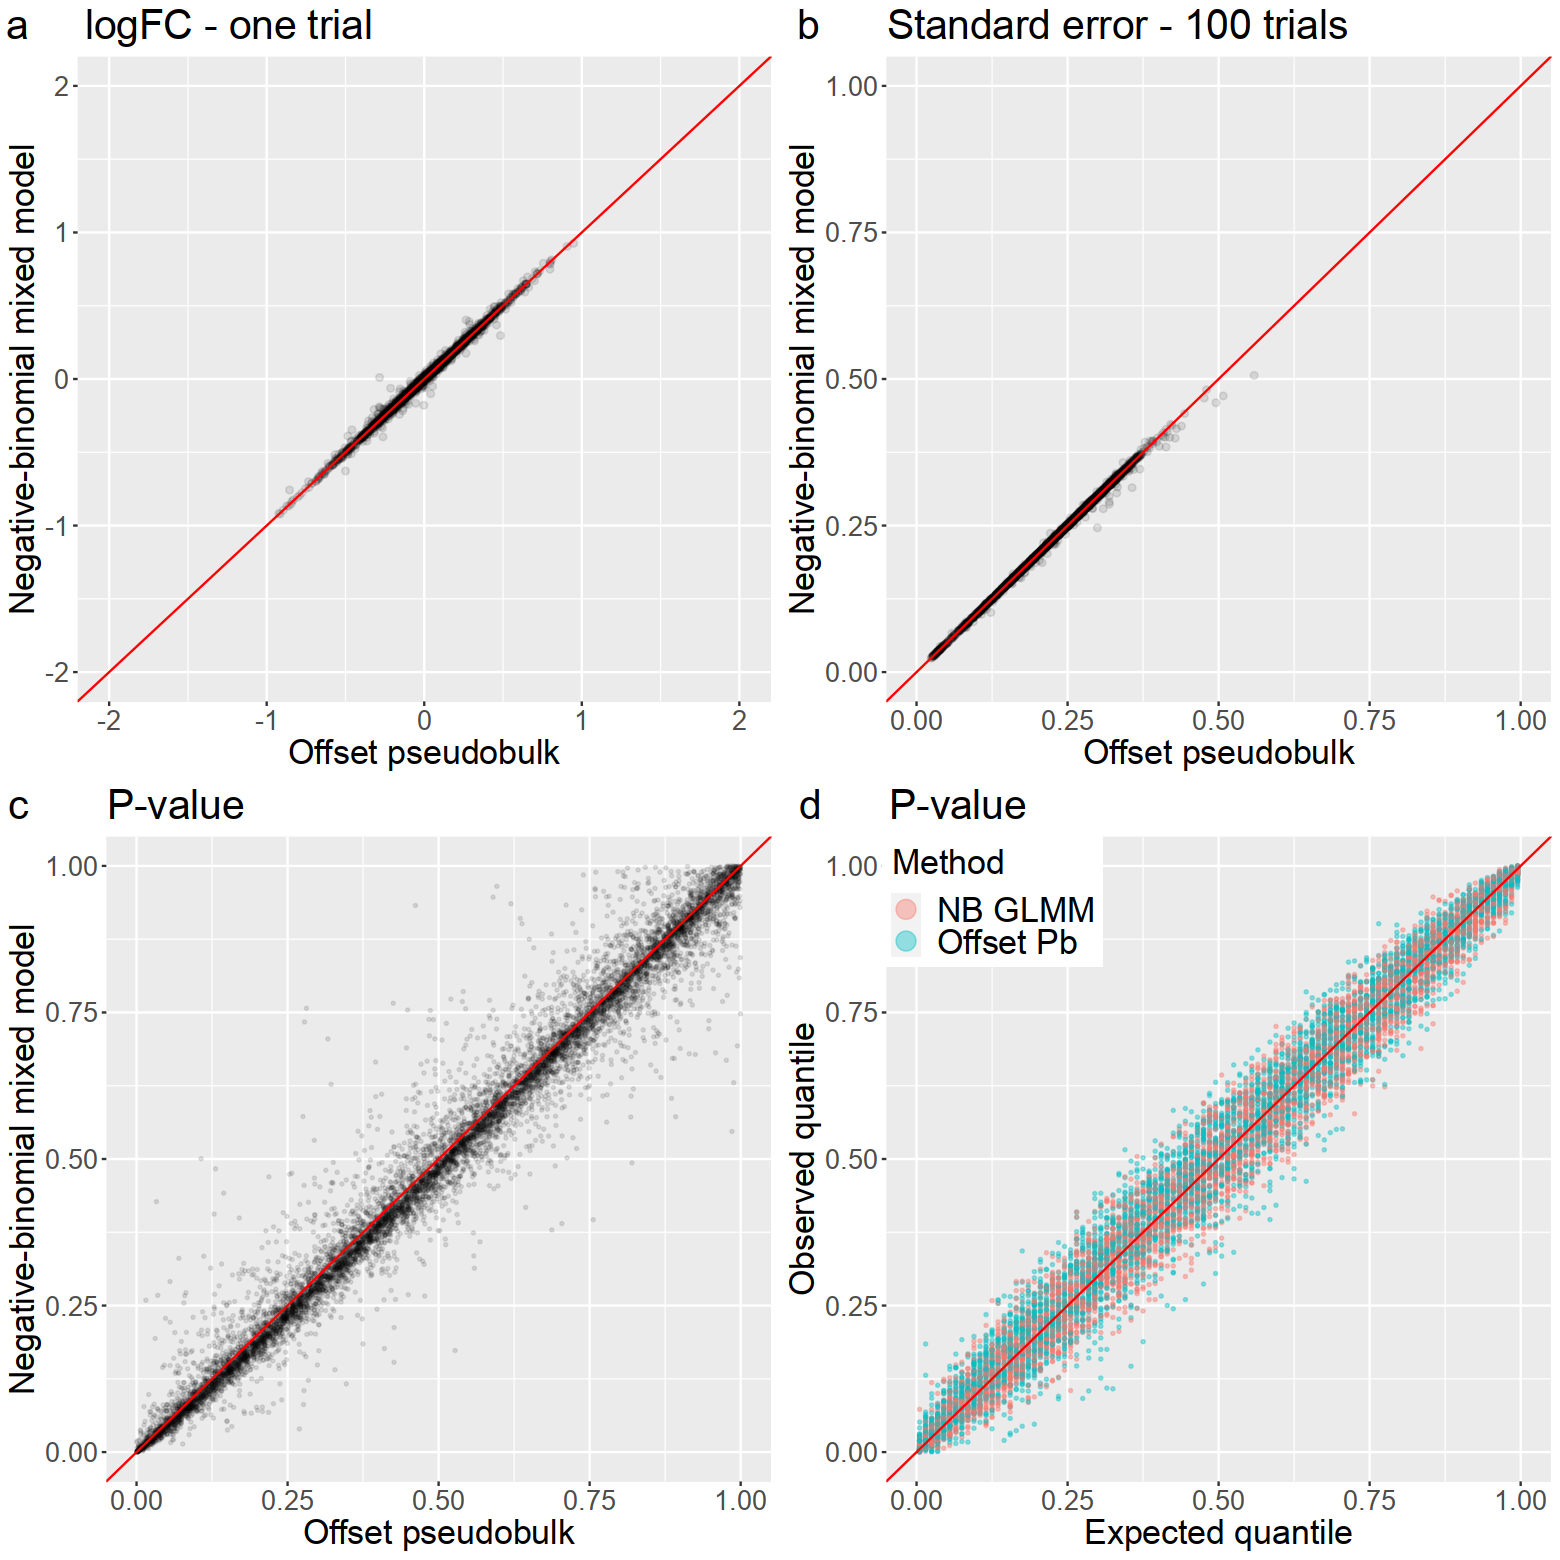

In [3]:
options(repr.plot.width=13, repr.plot.height=13)

# trial 1
x <- result.pb[[1]][,'Estimate']
y <- result.glmm[[1]][,'Estimate']
df <- data.frame(x,y)

p1 <- ggplot(df, aes(x=x, y=y), element_text(size = 20)) +
    geom_point(alpha=0.1) +
    xlim(c(-2,2)) +
    ylim(c(-2,2)) +
    labs(
        title="a     logFC - one trial",
         x ="Offset pseudobulk", 
         y = "Negative-binomial mixed model") +
    theme(text = element_text(size = 20),  plot.title = element_text(hjust = -0.22)) +
    geom_abline(color='red')

# standard error
x <- sqrt(rowVars(sapply(result.pb, function(df){ df[,'Estimate'] })))
y <- sqrt(rowVars(sapply(result.glmm, function(df){ df[,'Estimate'] })))
df <- data.frame(x,y)

p2 <- ggplot(df, aes(x=x, y=y), element_text(size = 20)) +
    geom_point(alpha=0.1) +
    xlim(c(0,1)) +
    ylim(c(0,1)) +
    labs(
        title="b      Standard error - 100 trials",
         x ="Offset pseudobulk", 
         y = "Negative-binomial mixed model") +
    theme(text = element_text(size = 20),  plot.title = element_text(hjust = -0.8)) +
    geom_abline(color='red')

# p-value compare
pb <- as.vector(sapply(result.pb, function(df){ df[,'Pr(>|t|)'] }))
glmm <- as.vector(sapply(result.glmm, function(df){ df[,'Pr(>|t|)'] }))
df.plot <- data.frame(pb=pb, glmm=glmm)
idx.plot <- sample(1:nrow(df.plot), size=10000)

p3 <- ggplot(df.plot[idx.plot,], aes(x=pb, y=glmm), element_text(size = 20)) +
    geom_point(alpha=0.1, size=0.5) +
    xlim(c(0,1)) +
    ylim(c(0,1)) +
    labs(
        title="c       P-value",
         x ="Offset pseudobulk", 
         y = "Negative-binomial mixed model") +
    theme(text = element_text(size = 20), plot.title = element_text(hjust = -0.23)) +
    geom_abline(color='red')

# qq-plot

n.transcripts <- nrow(result.pb[[1]])

df.1 <- t(sapply(result.pb, function(df){ df[,'Pr(>|t|)'] })) %>% 
    data.frame() %>%
    reshape2::melt() %>%
    group_by(variable) %>%
    arrange(value, .by_group = TRUE)
df.1$expected <- rep((1:100-0.5)/100, n.transcripts)

df.2 <- t(sapply(result.glmm, function(df){ df[,'Pr(>|t|)'] })) %>% 
    data.frame() %>%
    reshape2::melt() %>%
    group_by(variable) %>%
    arrange(value, .by_group = TRUE)
df.2$expected <- rep((1:100-0.5)/100, n.transcripts)

df.list <- list(df.1, df.2)
names(df.list) <- c('pb', 'glmm')
df.plot <- bind_rows(df.list, .id="method")

idx.plot <- sample(1:nrow(df.plot), size=10000)
p4 <- ggplot(df.plot[idx.plot,], aes(x=expected, y=value, color=method), element_text(size = 20)) +
    geom_point(alpha=0.4, size=0.5) +
    geom_abline(color='red') +
    xlim(c(0,1)) +
    ylim(c(0,1)) +
    labs(
        title="d      P-value",
         x ="Expected quantile", 
         y = "Observed quantile") +
    theme(text = element_text(size = 20)) +
    scale_color_discrete(name = "Method", labels = c("NB GLMM", "Offset Pb")) +
    theme(legend.text=element_text(size=20), legend.position=c(.16,.9), plot.title = element_text(hjust = -0.2)) +
    guides(colour = guide_legend(override.aes = list(size=5)))

grid.arrange(p1, p2, p3, p4, ncol=2, nrow=2)